In [1]:
import gym
import random
import numpy as np
from collections import namedtuple, deque
import matplotlib.pyplot as plt
import time

#pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##original reference code from: 
#https://github.com/g6ling/Reinforcement-Learning-Pytorch-Cartpole/tree/ecb7b622cfefe825ac95388cceb6752413d90a2a/PG/2-Actor-Critic

In [2]:
env = gym.make('CartPole-v1') #cartpole
start_time = time.time()

In [3]:
##Model (actor & critic sharing parameters)
class Actor(nn.Module):
    def __init__(self, num_inputs, num_hidden, num_outputs):
        super(Actor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(num_inputs, num_hidden),
            nn.ReLU(),
            #nn.Linear(num_hidden, num_outputs) 
        )
        
        self.actor_net = nn.Sequential(
            nn.Linear(num_hidden, num_outputs), 
            nn.Softmax(dim=1),
        )
        
        self.critic_net = nn.Linear(num_hidden, num_outputs)
        
    def forward(self, x):
        x = self.net(x)
        policy = self.actor_net(x)
        qvalue = self.critic_net(x)
        return policy, qvalue

In [4]:
## action selection
def get_action(state):
    policy, _ = policy_net(state)
    policy = policy[0].cpu().data.numpy()
    
    #choice(num_hidden,output_vector_size,probability_distribution)
    action = np.random.choice(2,1,p=policy)[0] 
    action = torch.tensor(action).to(device)
    return action.item()

In [5]:
#Initialize policy parameters
num_inputs = 4
num_hidden = 128
num_outputs = 2

policy_net = Actor(num_inputs, num_hidden, num_outputs).to(device) #.to(device)

gamma = 0.99
lr_actor = 1e-4

#optimizer & loss function
optimizer = optim.Adam(policy_net.parameters(), lr=lr_actor)
loss_fn = nn.MSELoss()

In [6]:
# train model
def train_model(policy_net, optimizer, transition, loss_fn):
    
    state, next_state, action, reward, mask = transition
    
    policy, qvalue = policy_net(state) #pi(s), q(s)
    _, next_qvalue = policy_net(next_state) # q(s')
    
    next_action = get_action(next_state) # a'
    
    # target = r + Y*q(s',a')
    target = reward + mask*gamma*next_qvalue[0][next_action]
    #print('target: ', target)

    # log_pi(s,a)
    log_policy = torch.log(policy[0])[action]
    #print('log_policy: ', log_policy)
    
    # -log_pi(s,a)*q(s,a)
    loss_policy = -log_policy*qvalue[0][action].item()
    
    # delta = r + q(s',a') - q(s,a)
    loss_value = loss_fn(qvalue[0][action],target.detach())
    
    # -log_pi(s,a)*q(s,a) + delta
    loss = loss_policy + loss_value
    #print('loss: ', loss)
    
    #weight updating
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()
    


In [7]:
steps = 0
loss = 0
running_score = 0
num_episodes = 3000

avg_loss,losses,cum_running_score,cum_rewards = [],[],[],[]
raw_score = []

for episode in range(num_episodes):
    done = False
    
    obs = env.reset()
    state = torch.tensor(obs).unsqueeze(0).to(device) #.to(device)
    #print('obs: ', obs)
    score = 0

    while not done:
        steps += 1
        
        action = get_action(state)
        next_obs, reward, done, _ = env.step(action)
        
        next_state = torch.tensor(next_obs).unsqueeze(0).to(device) #.to(device)
        
        mask = 0 if done else 1
        reward = -1/100 if done else reward/100 
        #reward = -1 if done else reward
        
        transition = [state, next_state, action, reward, mask]
        
        loss = train_model(policy_net, optimizer, transition, loss_fn)
        losses.append(loss)
        
        score += reward
        #print(score)
        state = next_state
        
    if losses: #execute if not empty
        avg_loss.append( np.mean(losses) )
        
    raw_score.append(score)     
    score = score if score == 500.0 else 100*score #100*score #+ 1/100
    
    running_score = 0.99*running_score + 0.01*score
    cum_running_score.append(running_score)
    cum_rewards.append(score)

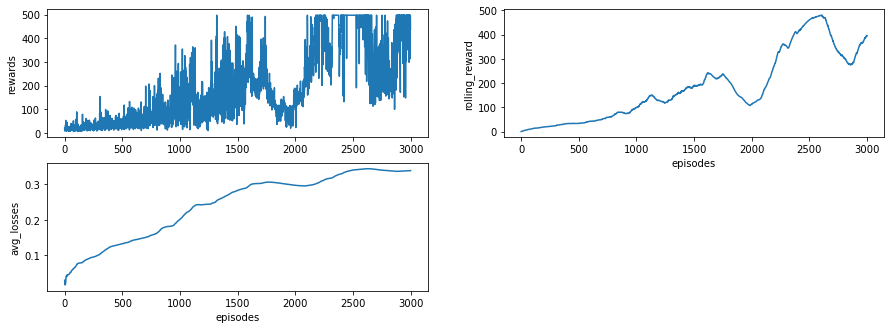

In [8]:
plt.figure(figsize=[15,8])
plt.subplot(3,2,1)
plt.plot(cum_rewards)
plt.ylabel('rewards')
#plt.xlabel('episodes')

plt.subplot(3,2,2)
plt.plot(cum_running_score)
plt.ylabel('rolling_reward')
plt.xlabel('episodes')

plt.subplot(3,2,3)
plt.plot(avg_loss) 
plt.ylabel('avg_losses')
plt.xlabel('episodes')

plt.show()

In [15]:
end_time = time.time()
duration = end_time - start_time
if duration > 3600: 
    print('{:.2f} hrs'.format(duration/3600))
else:
    print('{:.2f} min'.format(duration/60))

1.19 hrs
